In [ ]:
!pip install torchode
!pip install accelerate
!pip install torchdiffeq

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.4MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 367kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.76MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.98MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



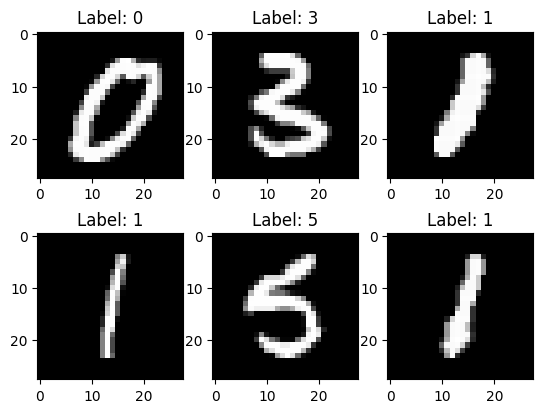

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchdiffeq import odeint
from torch.optim import Adam
from accelerate import Accelerator
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

examples = iter(train_loader)
images, labels = next(examples)

for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i][0], cmap='gray')
    plt.title(f'Label: {labels[i]}')
plt.show()


In [ ]:
class ODEFunc(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU()
        )

    def forward(self, t, y):
        return self.net(y)

class NeuralODE(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralODE, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.ode_func = ODEFunc(hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.input_layer(x))

        t_span = torch.linspace(0., 1., 20, device=x.device)
        y0 = x

        for atol, rtol in [(1e-3, 1e-3), (1e-5, 1e-5), (1e-1, 1e-1)]:
            states = odeint(self.ode_func, y0, t_span, method='dopri5', atol=atol, rtol=rtol)
            print(f"atol={atol}, rtol={rtol}, ODEStates shape: {states.shape}")

        states = odeint(self.ode_func, y0, t_span, method='dopri5', atol=1e-3, rtol=1e-3)
        x = states[-1]
        x = self.output_layer(x)
        return x



In [ ]:
accelerator = Accelerator()
device = accelerator.device

model = NeuralODE(input_dim=28*28, hidden_dim=64, output_dim=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.0001)

model, optimizer, train_loader, test_loader = accelerator.prepare(
    model, optimizer, train_loader, test_loader
)


Выходные данные были обрезаны до нескольких последних строк (5000).
atol=0.001, rtol=0.001, ODEStates shape: torch.Size([20, 64, 64])
atol=1e-05, rtol=1e-05, ODEStates shape: torch.Size([20, 64, 64])
atol=0.1, rtol=0.1, ODEStates shape: torch.Size([20, 64, 64])
atol=0.001, rtol=0.001, ODEStates shape: torch.Size([20, 64, 64])
atol=1e-05, rtol=1e-05, ODEStates shape: torch.Size([20, 64, 64])
atol=0.1, rtol=0.1, ODEStates shape: torch.Size([20, 64, 64])
atol=0.001, rtol=0.001, ODEStates shape: torch.Size([20, 64, 64])
atol=1e-05, rtol=1e-05, ODEStates shape: torch.Size([20, 64, 64])
atol=0.1, rtol=0.1, ODEStates shape: torch.Size([20, 64, 64])
atol=0.001, rtol=0.001, ODEStates shape: torch.Size([20, 64, 64])
atol=1e-05, rtol=1e-05, ODEStates shape: torch.Size([20, 64, 64])
atol=0.1, rtol=0.1, ODEStates shape: torch.Size([20, 64, 64])
atol=0.001, rtol=0.001, ODEStates shape: torch.Size([20, 64, 64])
atol=1e-05, rtol=1e-05, ODEStates shape: torch.Size([20, 64, 64])
atol=0.1, rtol=0.1, ODES

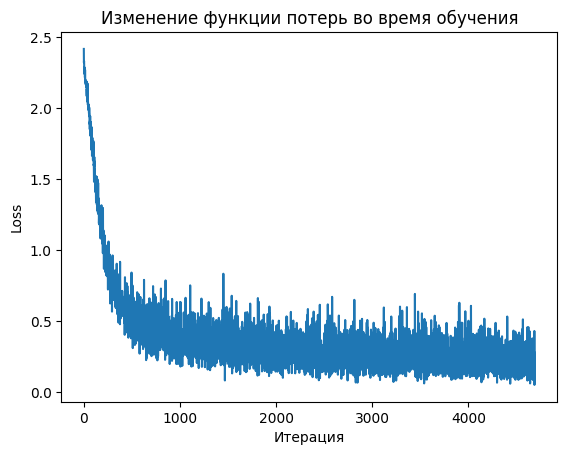

In [ ]:
losses = []
for epoch in range(5):
    model.train()
    for images, labels in train_loader:
        images = images.view(images.size(0), -1).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        accelerator.backward(loss)
        optimizer.step()

        losses.append(loss.item())

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

plt.plot(losses)
plt.xlabel("Итерация")
plt.ylabel("Loss")
plt.title("Изменение функции потерь во время обучения")
plt.show()


Выходные данные были обрезаны до нескольких последних строк (5000).
atol=0.001, rtol=0.001, ODEStates shape: torch.Size([20, 64, 64])
atol=1e-05, rtol=1e-05, ODEStates shape: torch.Size([20, 64, 64])
atol=0.1, rtol=0.1, ODEStates shape: torch.Size([20, 64, 64])
atol=0.001, rtol=0.001, ODEStates shape: torch.Size([20, 64, 64])
atol=1e-05, rtol=1e-05, ODEStates shape: torch.Size([20, 64, 64])
atol=0.1, rtol=0.1, ODEStates shape: torch.Size([20, 64, 64])
atol=0.001, rtol=0.001, ODEStates shape: torch.Size([20, 64, 64])
atol=1e-05, rtol=1e-05, ODEStates shape: torch.Size([20, 64, 64])
atol=0.1, rtol=0.1, ODEStates shape: torch.Size([20, 64, 64])
atol=0.001, rtol=0.001, ODEStates shape: torch.Size([20, 64, 64])
atol=1e-05, rtol=1e-05, ODEStates shape: torch.Size([20, 64, 64])
atol=0.1, rtol=0.1, ODEStates shape: torch.Size([20, 64, 64])
atol=0.001, rtol=0.001, ODEStates shape: torch.Size([20, 64, 64])
atol=1e-05, rtol=1e-05, ODEStates shape: torch.Size([20, 64, 64])
atol=0.1, rtol=0.1, ODES

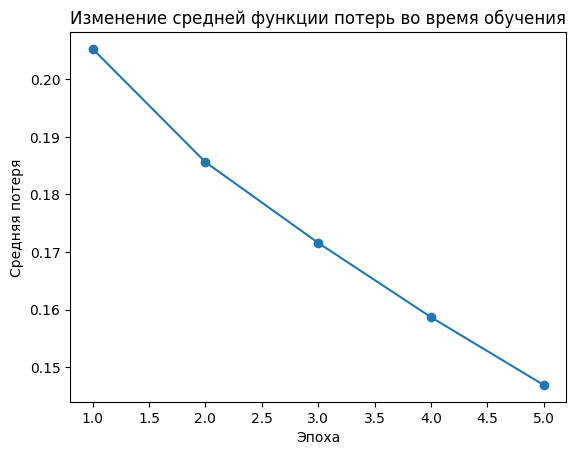

In [ ]:
losses_per_epoch = []

for epoch in range(5):
    model.train()
    epoch_loss = 0
    num_batches = 0

    for images, labels in train_loader:
        images = images.view(images.size(0), -1).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        accelerator.backward(loss)
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

    avg_loss = epoch_loss / num_batches
    losses_per_epoch.append(avg_loss)

    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")

plt.plot(range(1, len(losses_per_epoch) + 1), losses_per_epoch, marker='o')
plt.xlabel("Эпоха")
plt.ylabel("Средняя потеря")
plt.title("Изменение средней функции потерь во время обучения")
plt.show()


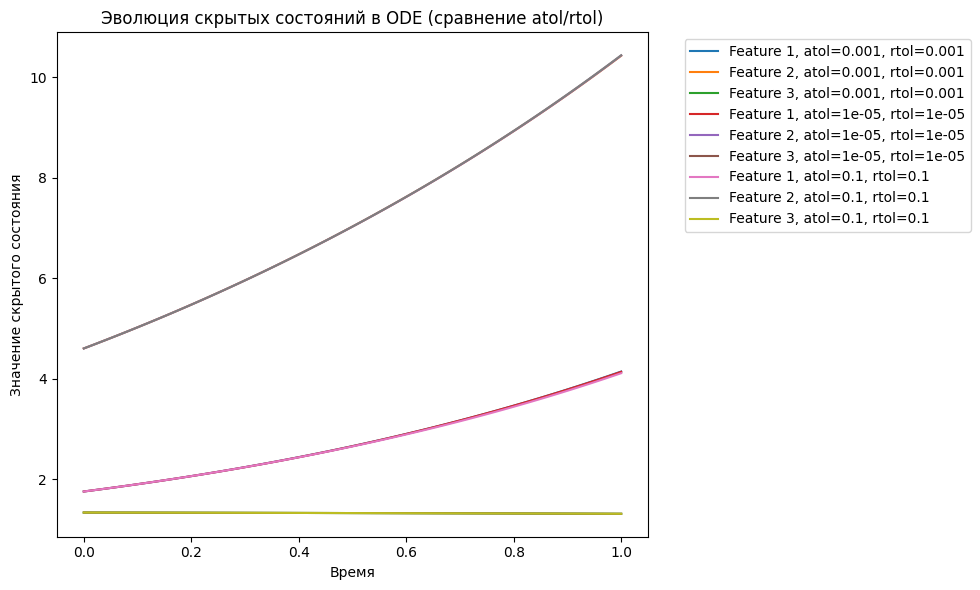

In [ ]:

x_test, _ = next(iter(test_loader))
x_test = x_test[0].view(1, -1).to(device)

tolerances = [(1e-3, 1e-3), (1e-5, 1e-5), (1e-1, 1e-1)]

plt.figure(figsize=(10, 6))
for atol, rtol in tolerances:
    with torch.no_grad():
        t_span = torch.linspace(0., 1., 100, device=x_test.device)
        y0 = F.relu(model.input_layer(x_test))
        states = odeint(model.ode_func, y0, t_span, method='dopri5', atol=atol, rtol=rtol)

    for i in range(min(3, states.shape[2])):
        plt.plot(
            t_span.cpu().numpy(),
            states[:, 0, i].cpu().numpy(),
            label=f"Feature {i+1}, atol={atol}, rtol={rtol}"
        )

plt.xlabel("Время")
plt.ylabel("Значение скрытого состояния")
plt.title("Эволюция скрытых состояний в ODE (сравнение atol/rtol)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()




# Эволюция почти одинаковая для разных atol и rtol, но можно заметить, что с течением времени появляется расходимость на концах

In [ ]:
model.eval()
total_correct = 0
total_samples = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(images.size(0), -1).to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

        total_correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)

accuracy = total_correct / total_samples
print(f"Test Accuracy: {accuracy * 100:.2f}%")


atol=0.001, rtol=0.001, ODEStates shape: torch.Size([20, 64, 64])
atol=1e-05, rtol=1e-05, ODEStates shape: torch.Size([20, 64, 64])
atol=0.1, rtol=0.1, ODEStates shape: torch.Size([20, 64, 64])
atol=0.001, rtol=0.001, ODEStates shape: torch.Size([20, 64, 64])
atol=1e-05, rtol=1e-05, ODEStates shape: torch.Size([20, 64, 64])
atol=0.1, rtol=0.1, ODEStates shape: torch.Size([20, 64, 64])
atol=0.001, rtol=0.001, ODEStates shape: torch.Size([20, 64, 64])
atol=1e-05, rtol=1e-05, ODEStates shape: torch.Size([20, 64, 64])
atol=0.1, rtol=0.1, ODEStates shape: torch.Size([20, 64, 64])
atol=0.001, rtol=0.001, ODEStates shape: torch.Size([20, 64, 64])
atol=1e-05, rtol=1e-05, ODEStates shape: torch.Size([20, 64, 64])
atol=0.1, rtol=0.1, ODEStates shape: torch.Size([20, 64, 64])
atol=0.001, rtol=0.001, ODEStates shape: torch.Size([20, 64, 64])
atol=1e-05, rtol=1e-05, ODEStates shape: torch.Size([20, 64, 64])
atol=0.1, rtol=0.1, ODEStates shape: torch.Size([20, 64, 64])
atol=0.001, rtol=0.001, ODESta

# Точность 95.44%

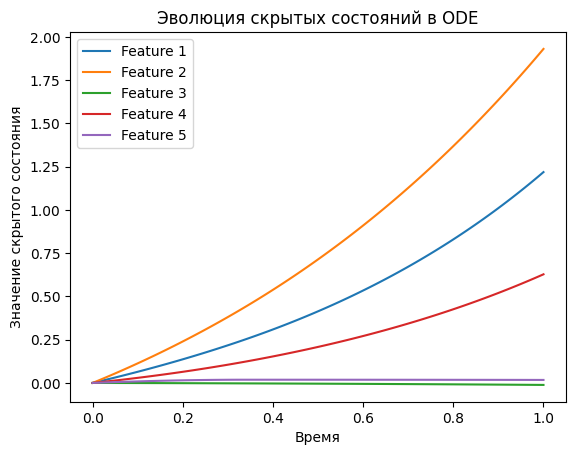

In [ ]:
x_test = torch.randn(1, 28*28).to(device)

with torch.no_grad():
    t_span = torch.linspace(0., 1., 100, device=x_test.device)
    y0 = F.relu(model.input_layer(x_test))
    states = odeint(model.ode_func, y0, t_span)

for i in range(min(5, states.shape[2])):
    plt.plot(t_span.cpu().numpy(), states[:, 0, i].cpu().numpy(), label=f"Feature {i+1}")

plt.xlabel("Время")
plt.ylabel("Значение скрытого состояния")
plt.title("Эволюция скрытых состояний в ODE")
plt.legend()
plt.show()


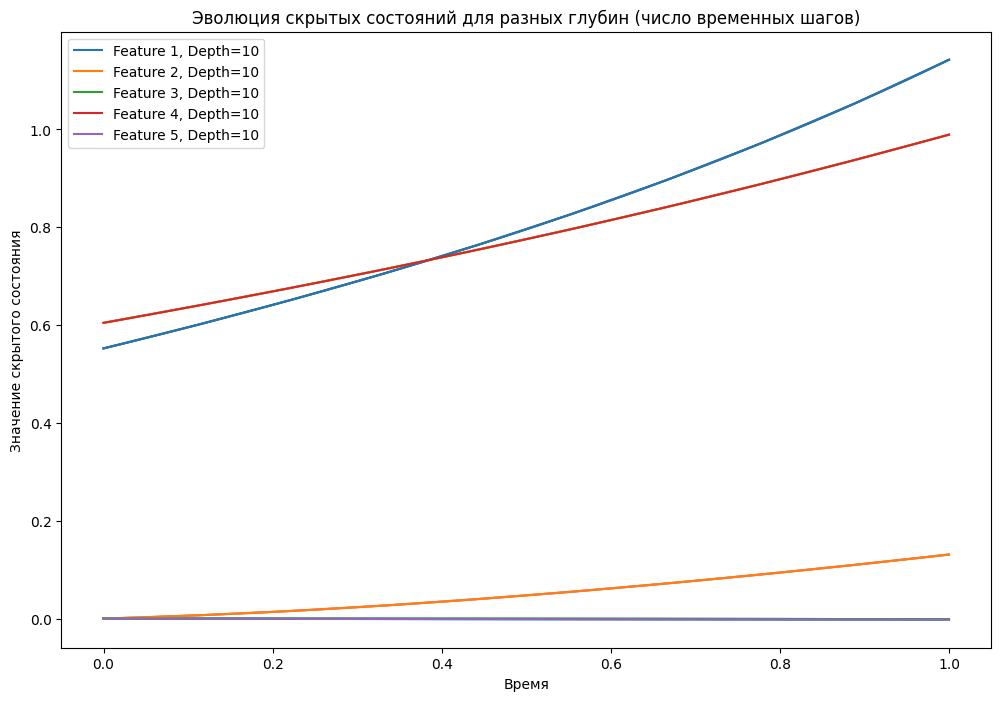

In [ ]:
import matplotlib.pyplot as plt

x_test = torch.randn(1, 28*28).to(device)
y0 = F.relu(model.input_layer(x_test))

plt.figure(figsize=(12, 8))

atol, rtol = 1e-3, 1e-3

depths = [10, 50, 100]

for depth in depths:
    t_span = torch.linspace(0., 1., depth, device=device)

    with torch.no_grad():
        states = odeint(model.ode_func, y0, t_span, method='dopri5', atol=atol, rtol=rtol)

    for i in range(min(5, states.shape[2])):
        plt.plot(
            t_span.cpu().numpy(),
            states[:, 0, i].cpu().numpy(),
            label=f"Feature {i+1}, Depth={depth}" if depth == depths[0] else ""
        )

plt.xlabel("Время")
plt.ylabel("Значение скрытого состояния")
plt.title("Эволюция скрытых состояний для разных глубин (число временных шагов)")
plt.legend()
plt.show()

